# Optimisation in a transformed parameter space

This example shows you how to run a global optimisation with a transformed parameter space. There are many benefits for parameter transformation, see e.g. \[1\], here we will show this in a practical point of view why parameter inference can be useful.

For a more elaborate example of an optimisation, see: [basic optimisation example](./first-example.ipynb).

First we will create a toy model which implements the logistic model.

\[1\]  Whittaker, DG, Clerx, M, Lei, CL, Christini, DJ, Mirams, GR. Calibration of ionic and cellular cardiac electrophysiology models. WIREs Syst Biol Med. 2020; 12:e1482. <https://doi.org/10.1002/wsbm.1482>

In [1]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt
import math

# Set some random seed so this notebook can be reproduced
np.random.seed(10)

# Load a logistic forward model
model = toy.LogisticModel()

We then define some parameters and set up the problem for the optimisation. The parameters for the toy logistic model are $[r, K]$, where $r$ is the rate and $K$ is the carrying capacity.

In [2]:
# Create some toy data
real_parameters = [0.015, 400]  # [r, K]
times = np.linspace(0, 1000, 1000)
values = model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

In this example, we will pick some consideringly difficult starting points for the optimisation.

In [3]:
x0 = [0.5, 0.1]  # [r, K]
sigma0 = [0.01, 2.0]

Let's run a Nelder-Mead optimisation without doing any parameter transformation to check its performance.

Minimising error measure
Using Nelder-Mead
Running in sequential mode.
Iter. Eval. Best      Time m:s
0     3      9.27e+07   0:00.0
1     4      9.27e+07   0:00.0
2     5      9.27e+07   0:00.0
3     6      9.27e+07   0:00.0
20    23     9.26e+07   0:00.0
40    43     9.25e+07   0:00.0
60    63     7.7e+07    0:00.0
80    83     2.58e+07   0:00.0
100   103    2.58e+07   0:00.0
120   123    2.58e+07   0:00.0
140   143    2.58e+07   0:00.0
160   167    2.58e+07   0:00.0
180   192    2.58e+07   0:00.0
200   217    2.58e+07   0:00.0
220   242    2.58e+07   0:00.0
240   269    2.58e+07   0:00.0
260   295    2.58e+07   0:00.0
280   322    2.58e+07   0:00.0
300   349    2.58e+07   0:00.0
320   375    2.58e+07   0:00.0
340   402    2.58e+07   0:00.0
360   429    2.58e+07   0:00.0
371   442    2.58e+07   0:00.0
Halting: No significant change for 200 iterations.
Score at true solution: 
87997.66499248528
Found solution:          True parameters:
 1.14854472655286514e+02     1.49999999999999994e

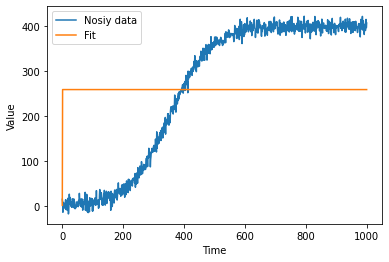

In [4]:
found_parameters, found_value = pints.optimise(
    score,
    x0,
    sigma0,
    method=pints.NelderMead,
    transform=None,
)

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

# Show quality of fit
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, values, label='Nosiy data')
plt.plot(times, problem.evaluate(found_parameters), label='Fit')
plt.legend()
plt.show()

Without the transformation, i.e. when the optimiser searched in $[r, K]$ space, it failed to converage to the true parameters. It gave up halfway in some very flat region.

Now, we will consider a log-transformation of $K$ parameter, so that we have the optimiser to search in $[r, \log(K)]$ space. It is as simple as to create a pints transformation object as following.

In [5]:
transform_r = pints.IdentityTransform(1)  # No transformation [r] -> [r]
transform_K = pints.LogTransform(1)  # log-transformation [K] -> [log(K)]
transform = pints.ComposedTransform(transform_r, transform_K)  # [r, K] -> [r, log(K)]

All we have to do is to pass the pints transformation\* to pints optimisation.

\* Note: we can use it in combination with any of pints' optimisation and [inference](../sampling/transformed-parameters.ipynb) algorithms. 

Minimising error measure
Using Nelder-Mead
Running in sequential mode.
Iter. Eval. Best      Time m:s
0     3      9.27e+07   0:00.0
1     4      9.27e+07   0:00.0
2     5      9.27e+07   0:00.0
3     6      9.26e+07   0:00.0
20    23     2.78e+07   0:00.0
40    43     2.54e+07   0:00.0
60    63     1.84e+07   0:00.0
80    83     9615881    0:00.0
100   103    126525.8   0:00.0
120   123    87941.33   0:00.0
140   143    87740.45   0:00.0
160   163    87740.34   0:00.0
180   183    87740.34   0:00.0
200   203    87740.34   0:00.0
220   223    87740.34   0:00.0
240   248    87740.34   0:00.0
260   272    87740.34   0:00.1
280   297    87740.34   0:00.1
300   323    87740.34   0:00.1
320   350    87740.34   0:00.1
340   377    87740.34   0:00.1
360   403    87740.34   0:00.1
380   430    87740.34   0:00.1
400   457    87740.34   0:00.1
420   483    87740.34   0:00.1
440   510    87740.34   0:00.1
460   537    87740.34   0:00.1
480   563    87740.34   0:00.1
483   566    87740.34   0:00.1

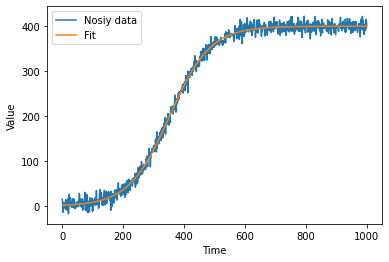

In [6]:
found_parameters, found_value = pints.optimise(
    score,
    x0,
    sigma0,
    method=pints.NelderMead,
    transform=transform,  # Pass the transformation to the optimiser
)

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

# Show quality of fit
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, values, label='Nosiy data')
plt.plot(times, problem.evaluate(found_parameters), label='Fit')
plt.legend()
plt.show()

With the log-transformation on one of the parameters, even we use the same data and the same initial positions for the same optimisation algorithm, it outperforms the one without transformation in this example (one converges to the true parameters and one does not!!), showing the importance of the transformation.